In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

gpd.options.use_pygeos = False
import zipfile
import os
import glob
import math


import matplotlib.pyplot as plt
from scipy.stats import entropy
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm
import scorers
import redistricting

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num


def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1
    else:
        return len(geometry.geoms)

In [3]:
data_path = "data_prep/output"
output_dir = "../output/"
run_name = "original_scorer_2020"
# states = pd.read_csv("../states_2010.csv")
states = glob.glob("data_prep/output/*")
DEGREE_LIMIT = 0
scoring = scorers.abs_diff_parta_fn
states

['data_prep/output\\az_2020',
 'data_prep/output\\ct_2020',
 'data_prep/output\\ga_2020',
 'data_prep/output\\ma_2020',
 'data_prep/output\\md_2020',
 'data_prep/output\\nc_2020',
 'data_prep/output\\nh_2020',
 'data_prep/output\\oh_2020',
 'data_prep/output\\pa_2020',
 'data_prep/output\\sc_2020',
 'data_prep/output\\tx_2020',
 'data_prep/output\\va_2020',
 'data_prep/output\\wi_2020']

In [4]:
# len(states['file'].value_counts())
len(states)

11

In [5]:
# for i,s in states.iterrows():
#     if type(s["file"]) == float:
#         if math.isnan(s["file"]):
#             continue

#     with zipfile.ZipFile(os.path.join(data_path,f"{s['file']}.zip"), 'r') as zip_ref:
#         zip_ref.extractall(os.path.join(data_path,s["abbrev"]))

#     data = gpd.read_file(os.path.join(data_path,s["abbrev"]))
#     if not(s["dem_votes"] in data.columns):
#         print(s["state"], "missing column.")

In [36]:
all_state_results = []

In [40]:
state_dict = dict(
    az_2020={"districts": 9, "crs": "EPSG:2223"},
    ct_2020={"districts": 5, "crs": "EPSG:2234"},
    ga_2020={"districts": 14, "crs": "EPSG:2240"},
    md_2020={"districts": 8, "crs": "EPSG:2248"},
    nc_2020={"districts": 14, "crs": "EPSG:2264"},
    nh_2020={"districts": 2, "crs": "EPSG:3437"},
    oh_2020={"districts": 15, "crs": "EPSG:2834"},
    pa_2020={"districts": 17, "crs": "EPSG:2271"},
    sc_2020={"districts": 7, "crs": "EPSG:2273"},
    va_2020={"districts": 11, "crs": "EPSG:2283"},
    wi_2020={"districts": 8, "crs": "EPSG:2288"},
    ma_2020={"districts": 9, "crs": "EPSG:2249"},
    tx_2020={"districts": 38, "crs": "EPSG:2277"},
)


for i, s in enumerate(states):
    if i < 8:
        continue
    state_file = s.split("\\")[-1]
    n_districts = state_dict[state_file]["districts"]
    print(i, state_file, n_districts)
    voting_precincts = gpd.read_file(s)

    orig_columns = list(voting_precincts.columns)
    voting_precincts = voting_precincts.to_crs(state_dict[state_file]["crs"])
    voting_precincts["geometry"] = voting_precincts["geometry"].apply(
        shapely.validation.make_valid
    )

    pop = "POP20"
    d_votes = "USH20_D"
    r_votes = "USH20_R"

    voting_precincts[d_votes] = voting_precincts[d_votes].fillna(0)
    voting_precincts[r_votes] = voting_precincts[r_votes].fillna(0)
    voting_precincts[pop] = voting_precincts[pop].fillna(0)

    voting_precincts[
        "REPRESENTATIVE_POINT"
    ] = (
        voting_precincts.centroid
    )  # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
    voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.x
    )
    voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.y
    )

    orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
        voting_precincts[[d_votes, r_votes]].sum().sum()
    )
    print(orig_voting)

    holder = []
    redistricting.split_this(
        df=voting_precincts,
        n_districts=n_districts,
        pop_col=pop,
        dem_col=d_votes,
        rep_col=r_votes,
        orig_dem=orig_voting[d_votes],
        orig_rep=orig_voting[r_votes],
        degree_limit=DEGREE_LIMIT,
        score_fn=scoring,
        holder=holder,
    )

    all_districts = pd.concat(holder).reset_index(drop=True)
    split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

    for c in split_columns:
        all_districts[c] = all_districts[c].fillna(0)

    all_districts["DISTRICT_"] = all_districts.apply(
        splits_to_regions_binary, splits=split_columns, axis=1
    )

    # Shuffle for coloring
    n_districts = all_districts["DISTRICT_"].nunique()
    random_districts = np.random.choice(
        np.linspace(0, n_districts - 1, n_districts),
        size=n_districts,
        replace=False,
        p=None,
    )
    shuffle_dict = dict(zip(all_districts["DISTRICT_"].unique(), random_districts))
    all_districts["SHUFFLED"] = all_districts["DISTRICT_"].apply(
        lambda x: shuffle_dict[x]
    )

    os.makedirs(os.path.join(output_dir, state_file), exist_ok=True)
    # all_districts[orig_columns + split_columns + ['SHUFFLED',"DISTRICT_"]].to_file(os.path.join(output_dir, state_file,f"{state_file}_{run_name}.shp"))

    voting_share = (
        all_districts.groupby("SHUFFLED")[["USH20_D", "USH20_R"]].sum().reset_index()
    )
    voting_share["Dem_Ratio"] = round(
        voting_share["USH20_D"] / (voting_share["USH20_R"] + voting_share["USH20_D"]), 2
    )
    comp_at_525 = voting_share.loc[
        (voting_share["Dem_Ratio"] >= 0.475) & (voting_share["Dem_Ratio"] <= 0.525)
    ].shape[0]
    comp_at_55 = voting_share.loc[
        (voting_share["Dem_Ratio"] >= 0.45) & (voting_share["Dem_Ratio"] <= 0.55)
    ].shape[0]
    print(voting_share.sort_values(by="Dem_Ratio"))

    all_state_results.append(
        {
            "state": state_file,
            "districts": state_dict[state_file]["districts"],
            "comp_at_525": comp_at_525,
            "comp_at_55": comp_at_55,
        }
    )

pd.DataFrame(all_state_results)

8 pa_2020 17
USH20_D    0.493685
USH20_R    0.506315
dtype: float64


100%|██████████| 360/360 [00:03<00:00, 96.55it/s] 


    SHUFFLED  USH20_D  USH20_R  Dem_Ratio
4        4.0   144819   226322       0.39
8        8.0   215337   229948       0.48
1        1.0   181694   186247       0.49
11      11.0   205407   216190       0.49
14      14.0   205205   201936       0.50
13      13.0   192358   193657       0.50
12      12.0   206042   206096       0.50
10      10.0   198444   196362       0.50
9        9.0   205227   204671       0.50
0        0.0   198838   199626       0.50
7        7.0   197361   198015       0.50
6        6.0   179016   175808       0.50
5        5.0   189399   186536       0.50
3        3.0   212504   212414       0.50
2        2.0   207013   206689       0.50
15      15.0   201221   200692       0.50
16      16.0   207536   191855       0.52
9 sc_2020 7
USH20_D    0.432652
USH20_R    0.567348
dtype: float64


100%|██████████| 360/360 [00:03<00:00, 114.28it/s]


   SHUFFLED  USH20_D  USH20_R  Dem_Ratio
1       1.0   100756   241401       0.29
6       6.0   112025   233829       0.32
3       3.0   153852   193934       0.44
0       0.0   159020   190438       0.46
2       2.0   176326   176339       0.50
4       4.0   183348   184152       0.50
5       5.0   187909   187270       0.50
10 tx_2020 38
USH20_D    0.452403
USH20_R    0.547597
dtype: float64


100%|██████████| 360/360 [00:03<00:00, 106.37it/s]


    SHUFFLED   USH20_D   USH20_R  Dem_Ratio
32      32.0   60240.0  260620.0       0.19
18      18.0   70020.0  247929.0       0.22
19      19.0   75489.0  248932.0       0.23
35      35.0   85929.0  239433.0       0.26
25      25.0   87921.0  222309.0       0.28
9        9.0   88796.0  205998.0       0.30
13      13.0  123166.0  185940.0       0.40
3        3.0  156930.0  162636.0       0.49
15      15.0  165100.0  169357.0       0.49
14      14.0  125511.0  131026.0       0.49
27      27.0  132439.0  135377.0       0.49
23      23.0  140548.0  140295.0       0.50
24      24.0  151591.0  152552.0       0.50
28      28.0  134549.0  137042.0       0.50
29      29.0  138763.0  138985.0       0.50
30      30.0  100782.0  100404.0       0.50
31      31.0  142173.0  143054.0       0.50
33      33.0  144512.0  143214.0       0.50
34      34.0  135630.0  137448.0       0.50
26      26.0  161080.0  158156.0       0.50
22      22.0  108896.0  109482.0       0.50
0        0.0  108659.0  109633.0

100%|██████████| 360/360 [00:02<00:00, 121.31it/s]


    SHUFFLED   USH20_D   USH20_R  Dem_Ratio
7        7.0  164194.0  176274.0       0.48
0        0.0  195094.0  194764.0       0.50
2        2.0  195466.0  194499.0       0.50
3        3.0  206370.0  209443.0       0.50
4        4.0  215883.0  212444.0       0.50
8        8.0  204715.0  207950.0       0.50
9        9.0  183530.0  184810.0       0.50
10      10.0  189864.0  192385.0       0.50
5        5.0  196650.0  189785.0       0.51
6        6.0  235029.0  170244.0       0.58
1        1.0  267179.0  115037.0       0.70
12 wi_2020 8
USH20_D    0.485246
USH20_R    0.514754
dtype: float64


100%|██████████| 360/360 [00:04<00:00, 73.48it/s]


   SHUFFLED   USH20_D   USH20_R  Dem_Ratio
1       1.0  152945.0  248222.0       0.38
0       0.0  176441.0  176373.0       0.50
2       2.0  208199.0  209790.0       0.50
3       3.0  208043.0  207970.0       0.50
4       4.0  200654.0  200547.0       0.50
5       5.0  208332.0  208004.0       0.50
6       6.0  207113.0  206314.0       0.50
7       7.0  204434.0  204179.0       0.50


,state,districts,comp_at_525,comp_at_55
0,az_2020,9,9,9
1,ct_2020,5,1,1
2,ga_2020,14,13,13
3,ma_2020,9,0,0
4,md_2020,8,3,3
5,nc_2020,14,13,14
6,nh_2020,2,1,1
7,oh_2020,15,8,9
8,pa_2020,17,16,16
9,sc_2020,7,3,4


In [41]:
pd.DataFrame(all_state_results).to_csv("state_results.csv", index=False)

In [9]:
os.path.join(output_dir, state_file, f"{state_file}_{run_name}.shp")

'../output/az_2020\\az_2020_original_scorer_2020.shp'

In [13]:
all_districts

,UNIQUE_ID,COUNTYFP,PCTNUM,PRECINCTNA,CDE_COUNTY,COUNTY_NAM,CON_DIST,SLDL_DIST,SLDU_DIST,USH20_D,...,RECENTERED_LON,RECENTERED_LAT,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,DISTRICT,SHUFFLED
0,206-OATMAN,015,MO0206,206 OATMAN,MO,Mohave,04,05,05,23.0,...,-514338.015486,464147.095377,137.936386,138.936386,1,1,1,1.0,15.0,6.0
1,203-YUCCA,015,MO0203,203 YUCCA,MO,Mohave,04,05,05,110.0,...,-448116.319971,384262.529676,139.386706,140.386706,1,1,1,1.0,15.0,6.0
2,212-MOHAVE VALLEY,015,MO0212,212 MOHAVE VALLEY,MO,Mohave,04,05,05,2634.0,...,-595731.043444,448597.416223,143.019520,144.019520,1,1,1,1.0,15.0,6.0
3,222-GOLDEN SHORES,015,MO0222,222 GOLDEN SHORES,MO,Mohave,04,05,05,245.0,...,-575781.274912,390841.606448,145.831252,146.831252,1,1,1,1.0,15.0,6.0
4,207-DESERT HILLS,015,MO0207,207 DESERT HILLS,MO,Mohave,04,05,05,378.0,...,-531363.647094,343701.949814,147.103999,148.103999,1,1,1,1.0,15.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,37 CASA GRANDE NW,021,PN0037,CASA GRANDE NW,PN,Pinal,01,11,11,1121.0,...,73088.871516,-18617.529933,345.709268,346.709268,0,0,0,0.0,0.0,7.0
1485,55 CASA GRANDE WEST,021,PN0055,CASA GRANDE WEST,PN,Pinal,01,11,11,774.0,...,88254.331581,-13585.665115,351.248716,352.248716,0,0,0,0.0,0.0,7.0
1486,39 CASA GRANDE RANCHO GRA,021,PN0039,CASA GRANDE RANCHO GRANDE,PN,Pinal,01,11,11,1063.0,...,106399.099497,-16208.052307,351.338572,352.338572,0,0,0,0.0,0.0,7.0
1487,83 COYOTE RANCH,021,PN0083,COYOTE RANCH,PN,Pinal,01,08,08,1010.0,...,114497.058205,-17309.121729,351.403390,352.403390,0,0,0,0.0,0.0,7.0


In [20]:
# os.makedirs(os.path.join(output_dir, s["abbrev"]),exist_ok=True)
voting_share = (
    all_districts.groupby("SHUFFLED")[["USH20_D", "USH20_R"]].sum().reset_index()
)
voting_share["Dem_Ratio"] = round(
    voting_share["USH20_D"] / (voting_share["USH20_R"] + voting_share["USH20_D"]), 2
)
comp_at_525 = voting_share.loc[
    (voting_share["Dem_Ratio"] >= 0.475) & (voting_share["Dem_Ratio"] <= 0.525)
].shape[0]
comp_at_55 = voting_share.loc[
    (voting_share["Dem_Ratio"] >= 0.45) & (voting_share["Dem_Ratio"] <= 0.55)
].shape[0]
voting_share.sort_values(by="Dem_Ratio")

,SHUFFLED,USH20_D,USH20_R,Dem_Ratio
7,7.0,165359.0,174849.0,0.49
0,0.0,198470.0,202251.0,0.50
1,1.0,143764.0,146070.0,0.50
2,2.0,180381.0,177211.0,0.50
3,3.0,210427.0,209935.0,0.50
4,4.0,201314.0,202330.0,0.50
5,5.0,177367.0,177402.0,0.50
6,6.0,157110.0,154947.0,0.50
8,8.0,195126.0,193521.0,0.50


In [21]:
comp_at_525

9

11 Hawaii


100%|██████████| 360/360 [00:02<00:00, 137.60it/s]
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


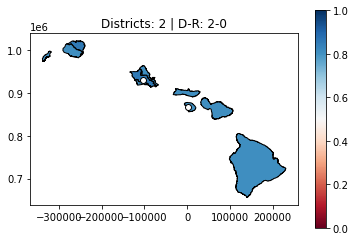

19 Maine


100%|██████████| 360/360 [00:04<00:00, 84.69it/s] 
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


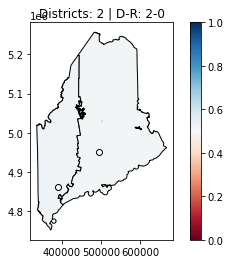

20 Maryland


100%|██████████| 360/360 [00:03<00:00, 110.35it/s]
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


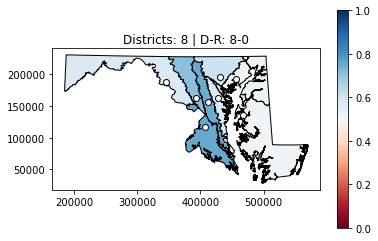

23 Minnesota


100%|██████████| 360/360 [00:07<00:00, 45.63it/s]
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


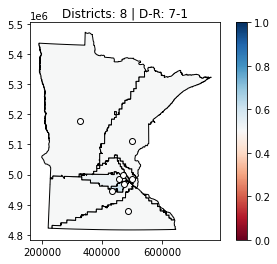

37 Oregon


100%|██████████| 360/360 [00:03<00:00, 110.71it/s]
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


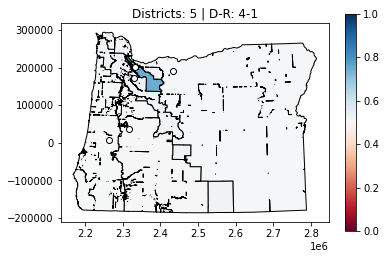

49 Wisconsin


100%|██████████| 360/360 [00:12<00:00, 29.00it/s]
c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


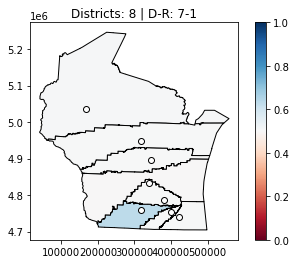

In [23]:
states_of_interest = ["Hawaii", "Maine", "Maryland", "Minnesota", "Oregon", "Wisconsin"]

for i, s in states.iterrows():
    if type(s["file"]) == float:
        if math.isnan(s["file"]):
            continue

    if s["state"] not in states_of_interest:
        continue

    print(i + 1, s["state"])

    voting_precincts = gpd.read_file(os.path.join(data_path, s["abbrev"]))

    # voting_precincts = voting_precincts.to_crs("EPSG:4269")
    # voting_precincts = voting_precincts.dissolve(by="COUNTYFP", aggfunc="sum")
    n_districts = s["districts"]
    pop = s["population"]
    d_votes = "USH16D"  # s["dem_votes"]
    r_votes = "USH16R"  # s["rep_votes"]
    if d_votes not in voting_precincts.columns:
        continue

    voting_precincts[pop] = voting_precincts[pop].astype(float)
    voting_precincts[d_votes] = voting_precincts[d_votes].astype(float)
    voting_precincts[r_votes] = voting_precincts[r_votes].astype(float)

    voting_precincts[
        "REPRESENTATIVE_POINT"
    ] = (
        voting_precincts.centroid
    )  # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
    voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.x
    )
    voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.y
    )

    orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
        voting_precincts[[d_votes, r_votes]].sum().sum()
    )

    holder = []
    redistricting.split_this(
        df=voting_precincts,
        n_districts=n_districts,
        pop_col=pop,
        dem_col=d_votes,
        rep_col=r_votes,
        orig_dem=orig_voting[d_votes],
        orig_rep=orig_voting[r_votes],
        degree_limit=DEGREE_LIMIT,
        score_fn=scoring,
        holder=holder,
    )

    all_districts = pd.concat(holder).reset_index(drop=True)
    split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

    for c in split_columns:
        all_districts[c] = all_districts[c].fillna(0)

    all_districts["DISTRICT"] = all_districts.apply(
        redistricting.splits_to_regions_binary, splits=split_columns, axis=1
    )

    n_districts = all_districts["DISTRICT"].nunique()
    random_districts = np.random.choice(
        np.linspace(0, n_districts - 1, n_districts),
        size=n_districts,
        replace=False,
        p=None,
    )
    shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
    all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(
        lambda x: shuffle_dict[x]
    )

    os.makedirs(os.path.join(output_dir, s["abbrev"]), exist_ok=True)
    all_districts[
        [
            "geometry",
            pop,
            "USH16D",
            "USH16R",
            "USH18D",
            "USH18R",
            "DISTRICT",
            "SHUFFLED",
        ]
        + split_columns
    ].to_file(os.path.join(output_dir, s["abbrev"], f"{s['abbrev']}_{run_name}.shp"))

    redistricting.split_review(
        input_df=all_districts,
        split=len(split_columns),
        split_cols=split_columns,
        d_votes=d_votes,
        r_votes=r_votes,
        pop=pop,
        plot_party=True,
        figsize=(6, 4),
        save=os.path.join(output_dir, s["abbrev"], f"{s['abbrev']}_{run_name}.png"),
    )

In [11]:
rows = []
for i, s in states.iterrows():
    if type(s["file"]) == float:
        if math.isnan(s["file"]):
            continue

    print(i + 1, s["state"])

    try:
        districts = gpd.read_file(
            os.path.join(output_dir, s["abbrev"], f"{s['abbrev']}_{run_name}.shp")
        )
    except:
        continue
    # voting_precincts = voting_precincts.to_crs("EPSG:4269")
    # voting_precincts = voting_precincts.dissolve(by="COUNTYFP", aggfunc="sum")
    n_districts = s["districts"]
    pop = s["population"]
    d_votes = "USH18D"  # s["dem_votes"]
    r_votes = "USH18R"  # s["rep_votes"]
    if d_votes not in districts.columns:
        continue

    districts[pop] = districts[pop].astype(float)
    districts[d_votes] = districts[d_votes].astype(float)
    districts[r_votes] = districts[r_votes].astype(float)

    districts_df = (
        districts.groupby("DISTRICT")
        .agg({d_votes: "sum", r_votes: "sum"})
        .reset_index()
    )
    districts_df["Dem_Ratio"] = districts_df[d_votes] / (
        districts_df[d_votes] + districts_df[r_votes]
    )
    districts_df["Rep_Ratio"] = districts_df[r_votes] / (
        districts_df[d_votes] + districts_df[r_votes]
    )

    n_districts = len(districts_df)
    dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= 0.5].shape[0]
    rep_wins = n_districts - dem_wins
    comp_districts = districts_df.loc[
        (districts_df["Dem_Ratio"] <= 0.55) & (districts_df["Rep_Ratio"] <= 0.55)
    ].shape[0]
    comp_districts2 = districts_df.loc[
        (districts_df["Dem_Ratio"] <= 0.525) & (districts_df["Rep_Ratio"] <= 0.525)
    ].shape[0]

    rows.append(
        {
            "state": s["state"],
            "districts": n_districts,
            "democrat_wins": dem_wins,
            "republican_wins": rep_wins,
            "competitive_districts_525": comp_districts2,
            "competitive_districts_55": comp_districts,
        }
    )

3 Arizona
6 Colorado
7 Connecticut
10 Georgia
11 Hawaii
14 Indiana
15 Iowa
18 Louisiana
19 Maine
20 Maryland
21 Massachusetts
22 Michigan
23 Minnesota
27 Nebraska
29 New Hampshire
31 New Mexico
33 North Carolina
35 Ohio
36 Oklahoma
37 Oregon
38 Pennsylvania
39 Rhode Island
44 Utah
46 Virginia
49 Wisconsin


In [12]:
results = pd.DataFrame(rows)
results

,state,districts,democrat_wins,republican_wins,competitive_districts_525,competitive_districts_55
0,Arizona,9,8,1,8,8
1,Colorado,7,6,1,4,4
2,Connecticut,5,5,0,1,1
3,Hawaii,2,2,0,0,0
4,Maine,2,1,1,1,1
5,Maryland,8,8,0,0,1
6,Minnesota,8,6,2,5,6
7,Nebraska,3,1,2,1,1
8,Oklahoma,5,0,5,1,1
9,Oregon,5,3,2,2,2


In [21]:
results.to_csv(os.path.join(output_dir, f"district_results_{run_name}"), index=False)

In [22]:
districts_df

,geometry,DISTRICT,USH16D,USH16R,Dem_Ratio,Rep_Ratio
DISTRICT,,,,,,
0,"MULTIPOLYGON (((167133.972 4878605.621, 167122...",0,162480.037466,161056.232289,0.502200,0.497800
1,"MULTIPOLYGON (((63731.557 4953390.906, 63716.4...",1,174829.000000,169632.000000,0.507544,0.492456
2,"MULTIPOLYGON (((205642.948 4726073.411, 205635...",2,159471.391868,160081.532370,0.499045,0.500955
3,"MULTIPOLYGON (((246473.106 4864206.164, 246518...",3,165900.126713,163936.916965,0.502976,0.497024
4,"MULTIPOLYGON (((403440.468 4768587.969, 403480...",4,172859.066512,172727.402488,0.500190,0.499810
5,"MULTIPOLYGON (((315548.562 4717222.944, 315533...",5,240694.377441,141120.915888,0.630395,0.369605
6,"MULTIPOLYGON (((358509.318 4705975.788, 358493...",6,162427.000000,161436.000000,0.501530,0.498470
7,"POLYGON ((434802.987 4704678.597, 434482.621 4...",7,141337.000000,140457.000000,0.501561,0.498439


In [16]:
districts = gpd.read_file(
    os.path.join(output_dir, s["abbrev"], f"{s['abbrev']}_{'2018_abs_both_comp'}.shp")
)
districts

,TOTPOP,USH18R,USH18D,DISTRICT,SHUFFLED,SPLIT_1,geometry
0,2164.0,450.0,815.0,1,1.0,1,"POLYGON ((501692.969 4901943.500, 500041.687 4..."
1,566.0,76.0,273.0,1,1.0,1,"POLYGON ((508378.344 4895531.500, 508310.844 4..."
2,1316.0,273.0,420.0,1,1.0,1,"POLYGON ((485036.094 4905721.000, 484322.406 4..."
3,2053.0,317.0,863.0,1,1.0,1,"POLYGON ((546312.500 4914754.000, 546381.375 4..."
4,516.0,142.0,127.0,1,1.0,1,"POLYGON ((575410.625 4919372.500, 575751.937 4..."
...,...,...,...,...,...,...,...
892,548.0,129.0,113.0,0,0.0,0,"POLYGON ((465319.906 4908825.500, 465184.531 4..."
893,141.0,31.0,82.0,0,0.0,0,"POLYGON ((566525.937 4904613.500, 569618.625 4..."
894,1563.0,282.0,460.0,0,0.0,0,"POLYGON ((548003.938 4908501.500, 548012.500 4..."
895,824.0,148.0,354.0,0,0.0,0,"POLYGON ((535677.375 4908335.500, 536012.500 4..."


In [24]:
rows = []
states_of_interest = ["Hawaii", "Maine", "Maryland", "Minnesota", "Oregon", "Wisconsin"]
for i, s in states.iterrows():
    if s["state"] not in states_of_interest:
        continue

    try:
        # voting_precincts = gpd.read_file(os.path.join(data_path,s["abbrev"]))
        districts = gpd.read_file(
            os.path.join(
                output_dir, s["abbrev"], f"{s['abbrev']}_{'2016_abs_both_comp'}.shp"
            )
        )
    except:
        continue

    n_districts = s["districts"]
    pop = s["population"]
    d_votes = "USH18D"  # s["dem_votes"]
    r_votes = "USH18R"  # s["rep_votes"]

    districts[pop] = districts[pop].astype(float)
    districts[d_votes] = districts[d_votes].astype(float)
    districts[r_votes] = districts[r_votes].astype(float)

    districts_df = (
        districts.groupby("DISTRICT")
        .agg({d_votes: "sum", r_votes: "sum"})
        .reset_index()
    )

    districts_df["Dem_Ratio"] = districts_df[d_votes] / (
        districts_df[d_votes] + districts_df[r_votes]
    )
    districts_df["Rep_Ratio"] = districts_df[r_votes] / (
        districts_df[d_votes] + districts_df[r_votes]
    )

    n_districts = len(districts_df)
    dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= 0.5].shape[0]
    rep_wins = n_districts - dem_wins
    comp_districts = districts_df.loc[
        (districts_df["Dem_Ratio"] <= 0.55) & (districts_df["Rep_Ratio"] <= 0.55)
    ].shape[0]
    comp_districts2 = districts_df.loc[
        (districts_df["Dem_Ratio"] <= 0.525) & (districts_df["Rep_Ratio"] <= 0.525)
    ].shape[0]

    rows.append(
        {
            "state": s["state"],
            "districts": n_districts,
            "democrat_wins": dem_wins,
            "republican_wins": rep_wins,
            "comp_districts_525": comp_districts2,
            "comp_districts_55": comp_districts,
        }
    )

In [ ]:
districts_df

,DISTRICT,USH18D,USH18R,Dem_Ratio,Rep_Ratio
0,0,134143.222071,181541.792234,0.424927,0.575073
1,1,144823.000000,177133.000000,0.449822,0.550178
2,2,154763.313585,154710.354351,0.500086,0.499914
3,3,144573.792855,179558.804781,0.446033,0.553967
4,4,183975.841167,149390.258217,0.551873,0.448127
5,5,270400.830323,54442.790417,0.832403,0.167597
6,6,174266.000000,142679.000000,0.549830,0.450170
7,7,160551.000000,133537.000000,0.545928,0.454072


In [25]:
results = pd.DataFrame(rows)
results

,state,districts,democrat_wins,republican_wins,comp_districts_525,comp_districts_55
0,Hawaii,2,2,0,0,0
1,Maine,2,2,0,0,0
2,Maryland,8,8,0,0,0
3,Minnesota,8,5,3,3,4
4,Oregon,5,5,0,1,2
5,Wisconsin,8,5,3,1,3


In [15]:
results.to_csv(os.path.join(output_dir, f"simulated_results_{run_name}"), index=False)